In [1]:
# !gsutil cp -r gs://volume_ai_1yr_daily_data/* /home/jupyter/lstm/

In [176]:
# !pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00a 0:00:01


## Install Package

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from plotnine import *
from plotnine.data import *
import random
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR
from captum.attr import IntegratedGradients
from plotnine.data import *
import seaborn as sns
import gc

## Read Data

### Behavior Event data

In [6]:
fea_data = pd.concat([pd.read_csv('/home/jupyter/lstm/data/VolumeAI_nonactive_ec_data_aggregate_1yr.csv')
                , pd.read_csv('/home/jupyter/lstm/data/VolumeAI_nonactive_feature__data_aggregate_1yr.csv')
                , pd.read_csv('/home/jupyter/lstm/data/VolumeAI_nonactive_popup__data_aggregate_1yr.csv')
                ])
fea_data['expired_date'] = fea_data['expired_date'].str[:10]
fea_data.shape

(43407210, 6)

In [3]:
fea_data_202401 = fea_data[fea_data['expired_date']=='2024-01-31']
feature_table_202401 = pd.pivot_table(fea_data_202401, values=['event_'], index=['hashed_sn', 'expired_date', 'event_day_diff'], columns=['event'], aggfunc="max", fill_value=0)

In [4]:
fea_data_202402 = fea_data[fea_data['expired_date']=='2024-02-29']
feature_table_202402 = pd.pivot_table(fea_data_202402, values=['event_'], index=['hashed_sn', 'expired_date', 'event_day_diff'], columns=['event'], aggfunc="max", fill_value=0)

In [5]:
fea_data_202403 = fea_data[fea_data['expired_date']=='2024-03-31']
feature_table_202403 = pd.pivot_table(fea_data_202403, values=['event_'], index=['hashed_sn', 'expired_date', 'event_day_diff'], columns=['event'], aggfunc="max", fill_value=0)

In [7]:
feature_table_202401 = feature_table_202401.reset_index()
feature_table_202402 = feature_table_202402.reset_index()
feature_table_202403 = feature_table_202403.reset_index()

In [8]:
feature_table_202401.columns = [''.join(col).strip() if isinstance(col, tuple) else col for col in feature_table_202401.columns]
feature_table_202402.columns = [''.join(col).strip() if isinstance(col, tuple) else col for col in feature_table_202402.columns]
feature_table_202403.columns = [''.join(col).strip() if isinstance(col, tuple) else col for col in feature_table_202403.columns]

In [9]:
event_day_diff = pd.DataFrame({'event_day_diff': list(range(0, 391, 1))})
sn_202401 = feature_table_202401[['hashed_sn', 'expired_date']].drop_duplicates().reset_index(drop=True)
sn_202401 = sn_202401.merge(event_day_diff, how='cross')

sn_202402 = feature_table_202402[['hashed_sn', 'expired_date']].drop_duplicates().reset_index(drop=True)
sn_202402 = sn_202402.merge(event_day_diff, how='cross')

sn_202403 = feature_table_202403[['hashed_sn', 'expired_date']].drop_duplicates().reset_index(drop=True)
sn_202403 = sn_202403.merge(event_day_diff, how='cross')

In [10]:
feature_table_202401[feature_table_202401.isna().any(axis=1)]
feature_table_202402[feature_table_202402.isna().any(axis=1)]
feature_table_202403[feature_table_202403.isna().any(axis=1)]

,hashed_sn,expired_date,event_day_diff,event_DP_introduction-end,event_DP_introduction-start,event_DTP_introduction-end,event_DTP_introduction-start,event_FS_introduction-end,event_FS_introduction-start,event_OpenMonthlyReportPopup,...,event_privacy_scanner_tb,event_pt_scan,event_quickScan,event_schedule_scan,event_secure_erase,event_stopRegularScan,event_updateManually,event_wifi_check,event_wtp,event_wtp_tb


In [13]:
feature_table_202401 = sn_202401.merge(feature_table_202401, how='left', on=['hashed_sn', 'expired_date', 'event_day_diff']).fillna(0)
feature_table_202401.to_csv('/home/jupyter/lstm/temp_table/df_feature_202401.csv', index=False)

In [ ]:
gc.collect()

In [15]:
feature_table_202402 = sn_202402.merge(feature_table_202402, how='left', on=['hashed_sn', 'expired_date', 'event_day_diff']).fillna(0)
feature_table_202402.to_csv('/home/jupyter/lstm/temp_table/df_feature_202402.csv', index=False)

0

In [ ]:
gc.collect()

In [11]:
feature_table_202403 = sn_202403.merge(feature_table_202403, how='left', on=['hashed_sn', 'expired_date', 'event_day_diff']).fillna(0)
feature_table_202403.to_csv('/home/jupyter/lstm/temp_table/df_feature_202403.csv', index=False)

In [ ]:
gc.collect()

### Analyze last ec day

In [ ]:
df_feature_202401 = pd.read_csv('/home/jupyter/lstm/temp_table/df_feature_202401.csv')

In [ ]:
user_list = pd.read_csv('/home/jupyter/lstm/data/VolumeAI_nonactive_sn_list_1yr.csv')
user_list['expiry_date'] = user_list['expiry_date'].str[:10]
expiry_date_list = ['2024-01-31']
user_list = user_list[user_list['expiry_date'].isin(expiry_date_list)]
user_list['hashed_sn'].nunique()

22020

In [ ]:
df_ec = df_feature_202401[['hashed_sn', 'event_day_diff', 'event_eclog']]

In [ ]:
df_ec['hashed_sn'].nunique()

20383

In [ ]:
user_renew = pd.read_csv('/home/jupyter/lstm/data/user_label_202401.csv')
user_renew

,hashed_sn,expired_date,Renew,Churn2
0,dc342fa7a7ca9c9b4efdb8118c744a411e67355d,2024-01-31T00:00:00Z,1,0
1,af4a5e27e1d002b7110c2e360af6f2d13c31d6f0,2024-01-31T00:00:00Z,0,1
2,6cde3462315d0922280ac24200e2ed4c779b09f7,2024-01-31T00:00:00Z,0,1
3,6aa20a851f13b815d082405d1715ca117c842858,2024-01-31T00:00:00Z,1,0
4,a106f89b04013c468d40321a2700a391e32ef04c,2024-01-31T00:00:00Z,1,0
...,...,...,...,...
147337,18e71dd400d799e31481d4a75f5746de5670abb5,2024-01-31T00:00:00Z,1,0
147338,5b4c9e494550885a3a2e123866fad23272ea5d27,2024-01-31T00:00:00Z,0,1
147339,981af2c5ecd8fa2633a5daab9a5e6ef78868b0a0,2024-01-31T00:00:00Z,1,0
147340,7947e094514c525ccea4fefee8de4fad7a5e1e80,2024-01-31T00:00:00Z,1,0


In [ ]:
df_ec['event_day_diff'] = df_ec['event_day_diff']*(-1)

/var/tmp/ipykernel_3379/2171617093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_ec['event_day_diff'] = df_ec['event_day_diff'].fillna(-400)

/var/tmp/ipykernel_3379/3231274296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_ec = df_ec[df_ec['event_eclog']==1]

In [ ]:
# max ec day
df_ec_last = df_ec.groupby(['hashed_sn'])['event_day_diff'].max().reset_index()

In [ ]:
df_ec_last = df_ec_last.merge(user_renew[['hashed_sn', 'Renew']], how='left', on='hashed_sn')
df_ec_last = df_ec_last.merge(user_list, how='left', on='hashed_sn')

In [ ]:
# specific ec range
df_ec_sn = pd.DataFrame({'hashed_sn': np.array(df_ec['hashed_sn'].unique())})
df_ec_sn

,hashed_sn
0,0008b2604e621b61740b50255a6b0eba0c1e139e
1,001159d7bda5935cead291f3a8f97fa7d9155f90
2,00162cd75cac32f350b0c42aff2f6d1a9910e059
3,001631cda48fb0f2c692109cee3c3f045cfe6ab3
4,001758d7a32b7d42f9fbb0d6cf0cdd35277b9d79
...,...
20273,ffeeb1ef976b3a20d1bc0a381f6c70aa347e9258
20274,fff4adafaf5abc382cf70ea509982544b1a1d1b3
20275,fff4b9f1c51e9f2b8688f21e5af042fcec1d2519
20276,fff4ffa932f99594ab650ab15d317d3676eff397


In [ ]:
# specific range: the 5th month
df_5th_ec = df_ec[(df_ec['event_day_diff']>-240) & (df_ec['event_day_diff']<=-210)][['hashed_sn', 'event_eclog']].drop_duplicates().reset_index(drop=True)
df_5th_ec = df_ec_sn.merge(df_5th_ec, how='left', on='hashed_sn')
df_5th_ec['event_eclog'] = df_5th_ec['event_eclog'].fillna(0)
df_5th_ec = df_5th_ec.merge(user_renew[['hashed_sn', 'Renew']], how='left', on='hashed_sn')
df_5th_ec

,hashed_sn,event_eclog,Renew
0,0008b2604e621b61740b50255a6b0eba0c1e139e,1.0,1
1,001159d7bda5935cead291f3a8f97fa7d9155f90,1.0,1
2,00162cd75cac32f350b0c42aff2f6d1a9910e059,1.0,0
3,001631cda48fb0f2c692109cee3c3f045cfe6ab3,1.0,1
4,001758d7a32b7d42f9fbb0d6cf0cdd35277b9d79,1.0,0
...,...,...,...
20273,ffeeb1ef976b3a20d1bc0a381f6c70aa347e9258,1.0,0
20274,fff4adafaf5abc382cf70ea509982544b1a1d1b3,1.0,1
20275,fff4b9f1c51e9f2b8688f21e5af042fcec1d2519,1.0,0
20276,fff4ffa932f99594ab650ab15d317d3676eff397,1.0,1


In [ ]:
df_5th_ec_check = df_5th_ec.groupby(['event_eclog', 'Renew'])['hashed_sn'].nunique().reset_index()
df_5th_ec_check['TTL_count'] = df_5th_ec_check['hashed_sn'].sum()
df_5th_ec_check['Renew_rate'] = df_5th_ec_check['hashed_sn'] / df_5th_ec_check['TTL_count']
df_5th_ec_check

,event_eclog,Renew,hashed_sn,TTL_count,Renew_rate
0,0.0,0,1685,20278,0.083095
1,0.0,1,1210,20278,0.059671
2,1.0,0,6412,20278,0.316205
3,1.0,1,10971,20278,0.541030


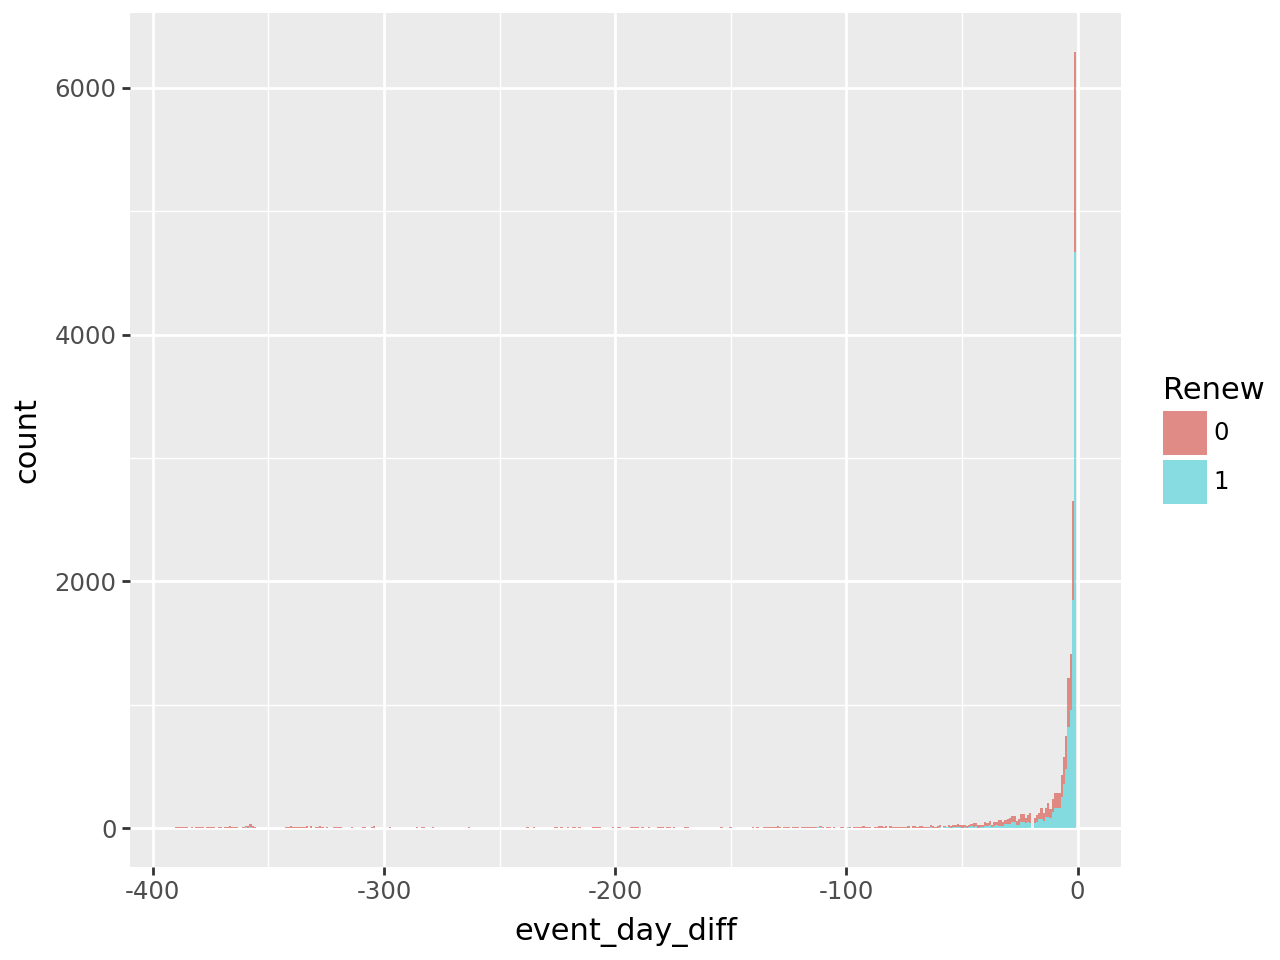

In [ ]:
df_ec_last['Renew'] = df_ec_last['Renew'].astype(str)
p = ggplot(df_ec_last, aes(x='event_day_diff', fill='Renew')) + geom_histogram(alpha=0.7, bins=400)
display(p)

/var/tmp/ipykernel_8268/2127658650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


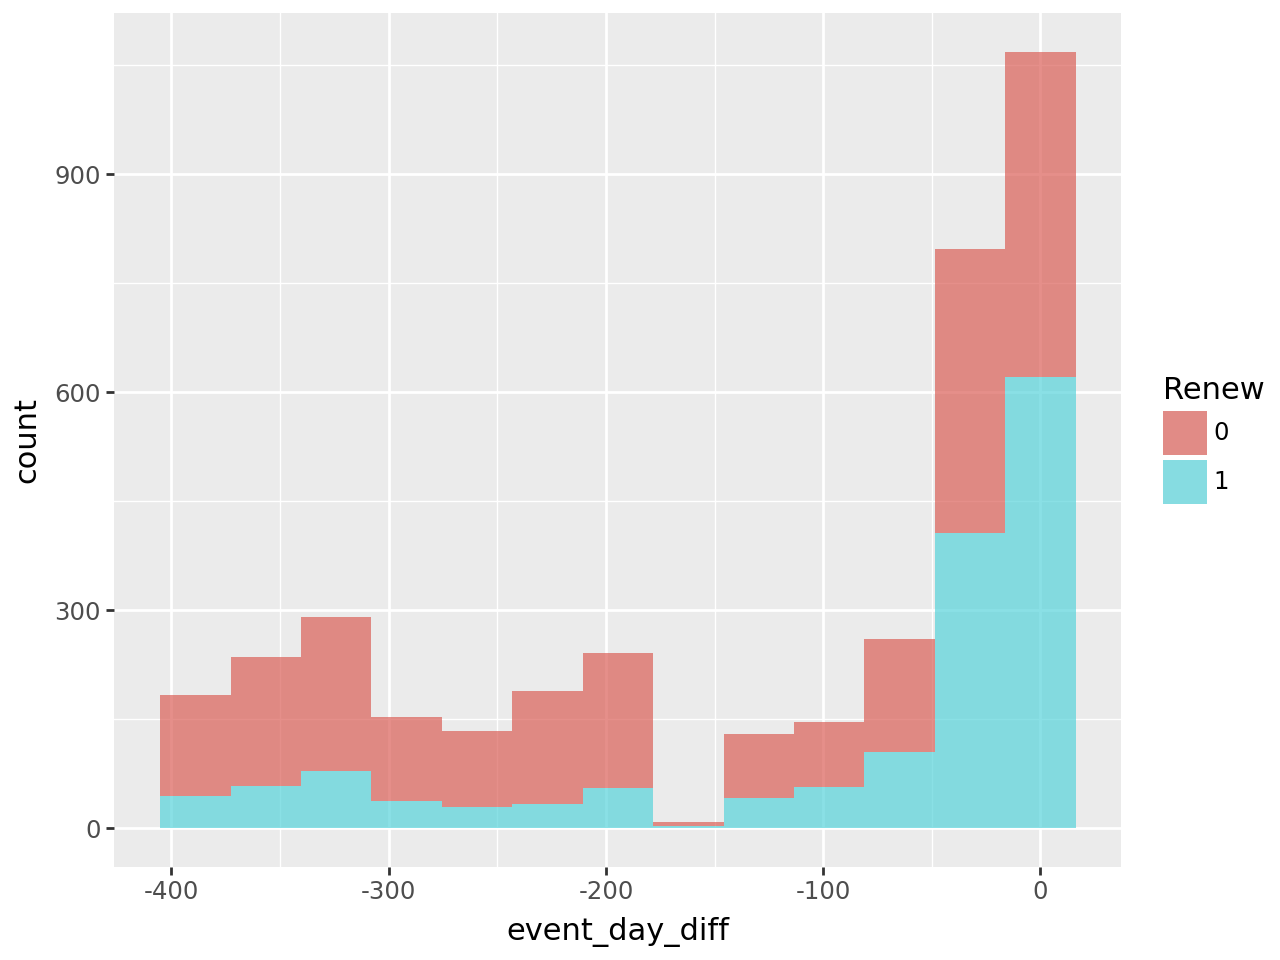

In [ ]:
check = df_ec_last[(df_ec_last['hashed_sn'].isin(df_ec_last[df_ec_last['non_active1']==True]['hashed_sn'].tolist()))]
check['Renew'] = check['Renew'].astype(str)
p = ggplot(check, aes(x='event_day_diff', fill='Renew')) + geom_histogram(alpha=0.7)  #
display(p)

In [ ]:
df_ec_check = df_ec_last.groupby(['non_active1', 'Renew'])['hashed_sn'].nunique().reset_index()
df_ec_check['TTL_count'] = df_ec_check['hashed_sn'].sum()
df_ec_check['Renew_rate'] = df_ec_check['hashed_sn'] / df_ec_check['TTL_count']
df_ec_check

,non_active1,Renew,hashed_sn,TTL_count,Renew_rate
0,False,0,5828,20278,0.287405
1,False,1,10609,20278,0.523178
2,True,0,2269,20278,0.111895
3,True,1,1572,20278,0.077522


In [ ]:
df_ec_check = df_ec_last.groupby(['non_active2', 'Renew'])['hashed_sn'].nunique().reset_index()
df_ec_check['TTL_count'] = df_ec_check['hashed_sn'].sum()
df_ec_check['Renew_rate'] = df_ec_check['hashed_sn'] / df_ec_check['TTL_count']
df_ec_check

,non_active2,Renew,hashed_sn,TTL_count,Renew_rate
0,False,0,5944,20278,0.293126
1,False,1,10850,20278,0.535063
2,True,0,2153,20278,0.106174
3,True,1,1331,20278,0.065638


In [ ]:
df_ec_check = df_ec_last.groupby(['non_active3', 'Renew'])['hashed_sn'].nunique().reset_index()
df_ec_check['TTL_count'] = df_ec_check['hashed_sn'].sum()
df_ec_check['Renew_rate'] = df_ec_check['hashed_sn'] / df_ec_check['TTL_count']
df_ec_check

,non_active3,Renew,hashed_sn,TTL_count,Renew_rate
0,False,0,5782,20278,0.285137
1,False,1,10822,20278,0.533682
2,True,0,2315,20278,0.114163
3,True,1,1359,20278,0.067018


In [ ]:
df_ec_check2 = df_ec_last.groupby(['Renew'])['hashed_sn'].nunique().reset_index()
df_ec_check2['TTL_count'] = df_ec_check2['hashed_sn'].sum()
df_ec_check2['Renew_rate'] = df_ec_check2['hashed_sn'] / df_ec_check2['TTL_count']
df_ec_check2

,Renew,hashed_sn,TTL_count,Renew_rate
0,0,8097,20278,0.3993
1,1,12181,20278,0.6007


Text(0.5, 1.0, 'Last Active Days Distribution')

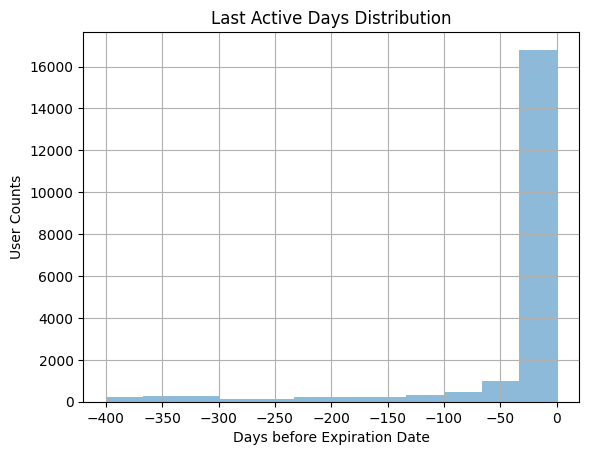

In [ ]:
df_ec_last['event_day_diff'].hist(bins=list(np.linspace(-400, 0, 13)), alpha=0.5)
plt.xlabel('Days before Expiration Date')
plt.ylabel('User Counts')
plt.title('Last Active Days Distribution')

In [ ]:
print(df_ec_last[df_ec_last['event_day_diff']>-180]['hashed_sn'].nunique())
print(df_ec_last[df_ec_last['event_day_diff']<=-180]['hashed_sn'].nunique())

18850
1428


In [ ]:
renewal_start_day = -90
non_active_group = eclog_dist_last[eclog_dist_last['event_day_diff']<=renewal_start_day]

2160


<Axes: >

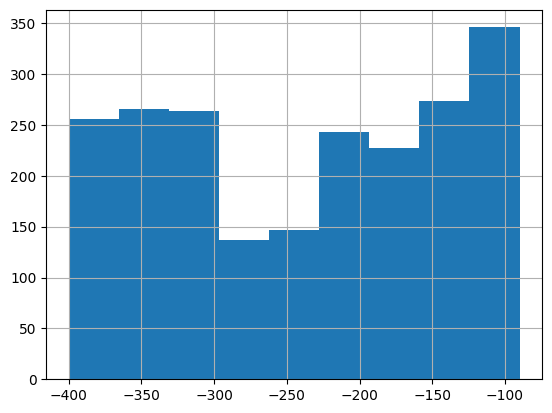

In [ ]:
print(non_active_group['hashed_sn'].nunique())
non_active_group['event_day_diff'].hist(bins=list(np.linspace(-400, -90, 10)))

In [ ]:
never_active = eclog_dist[eclog_dist['event_day_diff']==-400]

In [ ]:
print(eclog_dist_last[eclog_dist_last['event_day_diff']>-210]['hashed_sn'].count())
print(eclog_dist_last['hashed_sn'].count())

19084
20278
